# avanzado-y-extraccion-de-insights

### October 30, 2024

## 1 Análisis de Cohortes para Solicitudes de Adelanto en Efectivo y Tarifas Asociadas



## cash request fields description


| **Campo**                | **Descripción**                                                                                                                                                                                                                                                                                                                                                       |
|---------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **status**                | Estado del CR. <br> **Valores posibles:** <br> - `approved`: CR es "regular" (sin tarifas) y fue aprobado automáticamente o manualmente. Los fondos se enviarán aprox. 7 días después de su creación. <br> - `money_sent`: Transferimos los fondos a la cuenta del cliente. Cambiará a `active` cuando detectemos que el usuario recibió los fondos (usando el historial bancario del usuario). <br> - `rejected`: El CR requirió una revisión manual y fue rechazado. <br> - `pending`: El CR está pendiente de una revisión manual de un analista. <br> - `transaction_declined`: No logramos enviar los fondos al cliente. <br> - `waiting_user_confirmation`: El usuario debe confirmar en la aplicación que desea el CR (por razones legales). <br> - `direct_debit_rejected`: Nuestro último intento de débito directo SEPA para cobrar al cliente fue rechazado. <br> - `canceled`: El usuario no confirmó la solicitud de efectivo en la aplicación; la cancelamos automáticamente. <br> - `direct_debit_sent`: Enviamos/programamos un débito directo SEPA para cargar a la cuenta del cliente. El resultado de este débito aún no está confirmado. <br> - `waiting_reimbursement`: No pudimos estimar una fecha de reembolso; el usuario debe elegir una en la aplicación. <br> - `active`: Los fondos fueron recibidos en la cuenta del cliente. <br> - `money_back`: El CR fue reembolsado con éxito. |
| **reason**                | Se completa solo si el CR fue revisado manualmente y rechazado. Es la razón del rechazo que se muestra en la aplicación.                                                                                                                                                                                                                                              |
| **created_at**            | Marca de tiempo de la creación del CR.                                                                                                                                                                                                                                                                                                                               |
| **updated_at**            | Marca de tiempo de la última actualización de los detalles del CR (actualización de al menos una columna en esta tabla).                                                                                                                                                                                                                                            |
| **user_id**               | ID único del usuario que solicitó el adelanto de efectivo.                                                                                                                                                                                                                                                                                                          |
| **moderated_at**          | Marca de tiempo de la revisión manual. Solo se completa si el CR necesitó una revisión manual.                                                                                                                                                                                                                                                                      |
| **deleted_account_id**    | Si un usuario elimina su cuenta, reemplazamos el `user_id` con este ID. Corresponde a un ID único en la tabla de cuentas eliminadas con algunas claves de información guardadas para fines de lucha contra el fraude (respetando la regulación GDPR).                                                                                                               |
| **reimbursement_date**    | Fecha planificada de reembolso. La tarjeta del usuario se cargará en esta fecha.                                                                                                                                                                                                                                                                                    |
| **cash_request_debited_date** | Se completa solo si se envió un débito directo SEPA. Es la fecha en que se observó el último débito directo en la cuenta del usuario.                                                                                                                                                                                                                             |
| **cash_request_received_date** | Fecha de recepción del CR. Basado en el historial bancario del usuario.                                                                                                                                                                                                                                                                                          |
| **money_back_date**       | Fecha en que el CR fue considerado como `money_back`. Puede ser la fecha de `paid_by_card` o la fecha en que consideramos que el débito directo tiene pocas probabilidades de ser rechazado (según las reglas comerciales).                                                                                                                                           |
| **transfer_type**         | `Instant`: El usuario eligió no recibir el adelanto instantáneamente. <br> `Regular`: El usuario eligió no pagar y esperar el traspaso.                                                                                                                                                                                                                             |
| **send_at**               | Marca de tiempo de la transferencia de fondos.                                                                                                                                                                                                                                                                                                                      |
| **recovery_status**       | `Null` si el CR nunca tuvo un incidente de pago. <br> **Valores posibles:** <br> - `completed`: El incidente de pago fue resuelto (el CR fue reembolsado). <br> - `pending`: El incidente de pago sigue abierto. <br> - `pending_direct_debit`: El incidente de pago sigue abierto pero se lanzó un débito directo SEPA.                                                                                      |
| **reco_creation**         | Marca de tiempo de la creación de la recuperación.                                                                                                                                                                                                                                                                                                                  |
| **reco_last_update**      | Marca de tiempo de la última actualización del caso de recuperación. Puede usarse para determinar la fecha de cierre del incidente.                                                                                                                                                                                                                                 |



In [1]:
# Importar librerías necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Cargar el dataset principal de solicitudes de adelanto en efectivo
cash_request = pd.read_csv('project_dataset/extract - cash request - data analyst.csv')


In [3]:

# Inspeccionar la estructura y el tipo de datos de 'cash_request'
cash_request.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          23970 non-null  int64  
 1   amount                      23970 non-null  float64
 2   status                      23970 non-null  object 
 3   created_at                  23970 non-null  object 
 4   updated_at                  23970 non-null  object 
 5   user_id                     21867 non-null  float64
 6   moderated_at                16035 non-null  object 
 7   deleted_account_id          2104 non-null   float64
 8   reimbursement_date          23970 non-null  object 
 9   cash_request_received_date  16289 non-null  object 
 10  money_back_date             16543 non-null  object 
 11  transfer_type               23970 non-null  object 
 12  send_at                     16641 non-null  object 
 13  recovery_status             333

In [4]:
# Crear una copia del DataFrame para preservar el original
cr = cash_request.copy()



In [5]:
# Filtrar columnas relevantes para el análisis
cr = cr[["amount", "created_at", "user_id", "deleted_account_id","transfer_type"]]
cr.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   amount              23970 non-null  float64
 1   created_at          23970 non-null  object 
 2   user_id             21867 non-null  float64
 3   deleted_account_id  2104 non-null   float64
 4   transfer_type       23970 non-null  object 
dtypes: float64(3), object(2)
memory usage: 936.5+ KB


In [6]:
# Rellenar valores nulos en 'user_id' usando 'deleted_account_id' (clientes transferidos de cuentas eliminadas)
cr.fillna({"user_id": cr["deleted_account_id"]}, inplace=True)



In [7]:

# Eliminar la columna 'deleted_account_id' ya que no es necesaria después de la imputación
cr.drop(columns=["deleted_account_id"], inplace=True)
cr.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   amount         23970 non-null  float64
 1   created_at     23970 non-null  object 
 2   user_id        23970 non-null  float64
 3   transfer_type  23970 non-null  object 
dtypes: float64(2), object(2)
memory usage: 749.2+ KB


In [8]:

# Convertir 'created_at' a tipo datetime para manipulación de fechas
cr['created_at'] = pd.to_datetime(cr['created_at'])
cr.head()



,amount,created_at,user_id,transfer_type
0,100.0,2019-12-10 19:05:21.596873+00:00,804.0,regular
1,100.0,2019-12-10 19:50:12.347780+00:00,231.0,regular
2,100.0,2019-12-10 19:13:35.825460+00:00,191.0,regular
3,99.0,2019-12-10 19:16:10.880172+00:00,761.0,regular
4,100.0,2020-05-06 09:59:38.877376+00:00,7686.0,regular


In [9]:

# Convertir la columna 'created_at' a una fecha sin zona horaria
cr['created_at'] = cr['created_at'].dt.tz_localize(None)
cr.head()


,amount,created_at,user_id,transfer_type
0,100.0,2019-12-10 19:05:21.596873,804.0,regular
1,100.0,2019-12-10 19:50:12.347780,231.0,regular
2,100.0,2019-12-10 19:13:35.825460,191.0,regular
3,99.0,2019-12-10 19:16:10.880172,761.0,regular
4,100.0,2020-05-06 09:59:38.877376,7686.0,regular


In [10]:
# Crear columna 'Mes' indicando el mes de cada solicitud
cr['Mes'] = cr['created_at'].dt.to_period('M')
cr.head()


,amount,created_at,user_id,transfer_type,Mes
0,100.0,2019-12-10 19:05:21.596873,804.0,regular,2019-12
1,100.0,2019-12-10 19:50:12.347780,231.0,regular,2019-12
2,100.0,2019-12-10 19:13:35.825460,191.0,regular,2019-12
3,99.0,2019-12-10 19:16:10.880172,761.0,regular,2019-12
4,100.0,2020-05-06 09:59:38.877376,7686.0,regular,2020-05


In [11]:
# Crear columna 'Cohorte' que indica el mes de la primera solicitud de cada cliente
cr['Cohorte'] = cr.groupby('user_id')['created_at'].transform('min').dt.to_period('M')
cr.head(10)


,amount,created_at,user_id,transfer_type,Mes,Cohorte
0,100.0,2019-12-10 19:05:21.596873,804.0,regular,2019-12,2019-12
1,100.0,2019-12-10 19:50:12.347780,231.0,regular,2019-12,2019-12
2,100.0,2019-12-10 19:13:35.825460,191.0,regular,2019-12,2019-12
3,99.0,2019-12-10 19:16:10.880172,761.0,regular,2019-12,2019-12
4,100.0,2020-05-06 09:59:38.877376,7686.0,regular,2020-05,2020-05
5,100.0,2020-05-23 20:58:55.129432,9489.0,regular,2020-05,2020-05
6,100.0,2020-06-16 17:07:38.452652,14631.0,regular,2020-06,2020-06
7,100.0,2020-02-10 01:11:53.808270,309.0,regular,2020-02,2020-01
8,100.0,2020-06-28 12:06:33.712840,2499.0,regular,2020-06,2020-06
9,90.0,2019-12-10 19:51:23.911206,897.0,regular,2019-12,2019-12


In [12]:
# Calcular el número inicial de clientes únicos en cada cohorte
cohort_sizes_initial = cr.groupby('Cohorte').agg(Num_Clientes_Iniciales=('user_id', 'nunique')).reset_index()
cohort_sizes_initial


,Cohorte,Num_Clientes_Iniciales
0,2019-11,1
1,2019-12,254
2,2020-01,106
3,2020-02,90
4,2020-03,86
5,2020-04,246
6,2020-05,432
7,2020-06,1540
8,2020-07,1482
9,2020-08,728


In [13]:
# Calcular la cantidad de clientes únicos en cada cohorte para cada mes
cohort_sizes_monthly = cr.groupby(['Cohorte', 'Mes']).agg(Num_Clientes=('user_id', 'nunique')).reset_index()
cohort_sizes_monthly


,Cohorte,Mes,Num_Clientes
0,2019-11,2019-11,1
1,2019-11,2019-12,1
2,2019-11,2020-04,1
3,2019-11,2020-05,1
4,2019-11,2020-08,1
...,...,...,...
78,2020-09,2020-10,680
79,2020-09,2020-11,20
80,2020-10,2020-10,4802
81,2020-10,2020-11,15


In [14]:
# Calcular la cantidad de solicitudes de adelanto de efectivo de los clientes de cada cohorte en cada mes
cohort_cash_monthly = cr.groupby(['Cohorte', 'Mes']).agg(Num_Solicitudes=('user_id', 'count')).reset_index()
cohort_cash_monthly


,Cohorte,Mes,Num_Solicitudes
0,2019-11,2019-11,1
1,2019-11,2019-12,1
2,2019-11,2020-04,1
3,2019-11,2020-05,1
4,2019-11,2020-08,1
...,...,...,...
78,2020-09,2020-10,727
79,2020-09,2020-11,20
80,2020-10,2020-10,5043
81,2020-10,2020-11,15


In [15]:
# Calcular la tasa de retención de clientes (clientes únicos por cohorte en cada mes / clientes iniciales de la cohorte) 
retention_clientes = cohort_sizes_monthly.pivot(index='Cohorte', columns='Mes',values='Num_Clientes')
retention_clientes = retention_clientes.div(cohort_sizes_initial.set_index('Cohorte')['Num_Clientes_Iniciales'], axis=0)
retention_clientes


Mes,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
Cohorte,,,,,,,,,,,,,
2019-11,1.0,1.0,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.000000,1.000000,NaN
2019-12,NaN,1.0,0.354331,0.228346,0.267717,0.263780,0.295276,0.287402,0.232283,0.263780,0.169291,0.244094,0.003937
2020-01,NaN,NaN,1.000000,0.207547,0.150943,0.254717,0.254717,0.254717,0.264151,0.198113,0.188679,0.226415,0.009434
2020-02,NaN,NaN,NaN,1.000000,0.500000,0.466667,0.466667,0.433333,0.433333,0.400000,0.277778,0.377778,NaN
2020-03,NaN,NaN,NaN,NaN,1.000000,0.441860,0.430233,0.523256,0.418605,0.395349,0.337209,0.313953,0.011628
2020-04,NaN,NaN,NaN,NaN,NaN,1.000000,0.471545,0.495935,0.373984,0.325203,0.308943,0.247967,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.590278,0.506944,0.430556,0.340278,0.356481,0.009259
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.490909,0.482468,0.372727,0.367532,0.003247
2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.474359,0.344804,0.359649,0.004723


Text(95.72222222222221, 0.5, 'Cohorte')

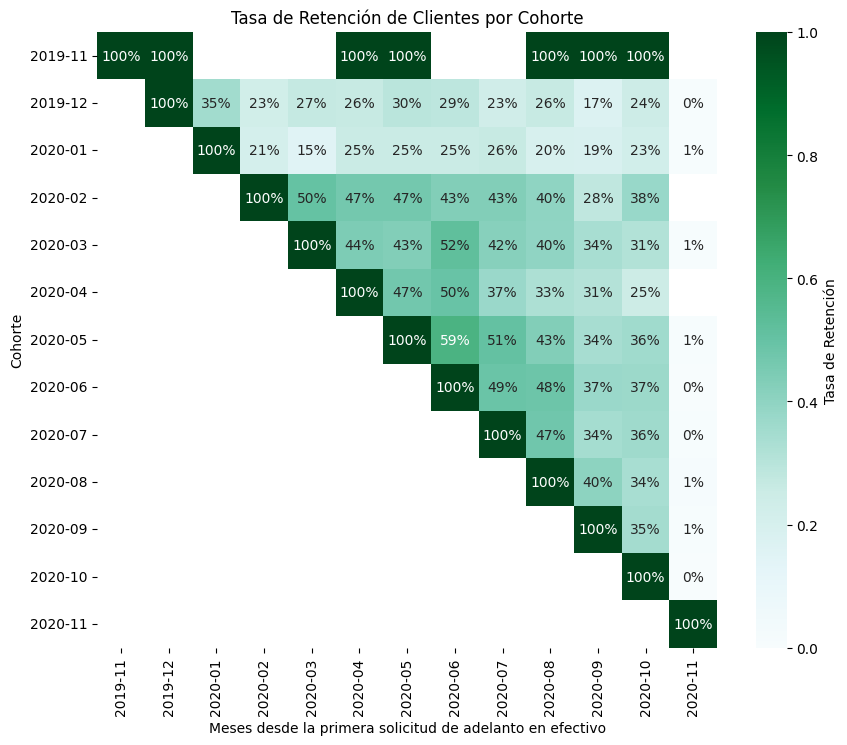

In [16]:
# Visualizar la tasa de retención de clientes usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Retención de Clientes por Cohorte')
sns.heatmap(data=retention_clientes, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='BuGn', cbar_kws={'label': 'Tasa de Retención'})
plt.xlabel('Meses desde la primera solicitud de adelanto en efectivo')
plt.ylabel('Cohorte')


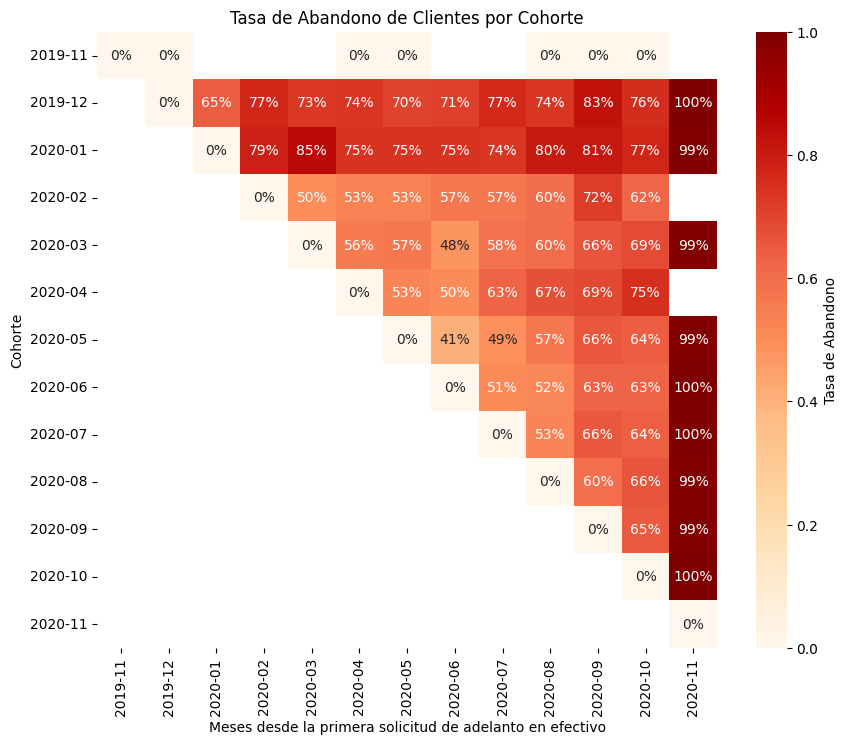

In [17]:
# Calcular la tasa de abandono de clientes (1 - tasa de retención)
churn_clientes = 1 - retention_clientes
# Visualizar la tasa de abandono de clientes usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Abandono de Clientes por Cohorte')
sns.heatmap(data=churn_clientes, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='OrRd', cbar_kws={'label': 'Tasa de Abandono'})
plt.xlabel('Meses desde la primera solicitud de adelanto en efectivo')
plt.ylabel('Cohorte')
plt.show()



In [18]:
# Calcular el número inicial de solicitudes de adelanto de efectivo en cada cohorte
cohort_cash_initial = cohort_cash_monthly.groupby('Cohorte').first().reset_index().rename(columns={'Num_Solicitudes':'Num_Solicitudes_Iniciales'})
cohort_cash_initial


,Cohorte,Mes,Num_Solicitudes_Iniciales
0,2019-11,2019-11,1
1,2019-12,2019-12,288
2,2020-01,2020-01,117
3,2020-02,2020-02,97
4,2020-03,2020-03,99
5,2020-04,2020-04,264
6,2020-05,2020-05,478
7,2020-06,2020-06,1934
8,2020-07,2020-07,1996
9,2020-08,2020-08,993


In [19]:
# Calcular la tasa de retención de solicitudes (solicitudes por cohorte en cada mes / solicitudes iniciales de la cohorte)
retention_cash = cohort_cash_monthly.pivot(index='Cohorte', columns='Mes',values='Num_Solicitudes')
retention_cash = retention_cash.div(cohort_cash_initial.set_index('Cohorte')['Num_Solicitudes_Iniciales'], axis=0)
retention_cash


Mes,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
Cohorte,,,,,,,,,,,,,
2019-11,1.0,1.0,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.000000,2.000000,NaN
2019-12,NaN,1.0,0.368056,0.218750,0.274306,0.284722,0.298611,0.315972,0.250000,0.291667,0.184028,0.260417,0.003472
2020-01,NaN,NaN,1.000000,0.205128,0.145299,0.299145,0.264957,0.247863,0.264957,0.188034,0.188034,0.213675,0.008547
2020-02,NaN,NaN,NaN,1.000000,0.505155,0.505155,0.463918,0.463918,0.463918,0.453608,0.278351,0.412371,NaN
2020-03,NaN,NaN,NaN,NaN,1.000000,0.424242,0.464646,0.474747,0.404040,0.363636,0.303030,0.303030,0.010101
2020-04,NaN,NaN,NaN,NaN,NaN,1.000000,0.568182,0.571970,0.439394,0.405303,0.337121,0.284091,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.665272,0.573222,0.485356,0.376569,0.364017,0.008368
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.531024,0.494829,0.355222,0.339193,0.002585
2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.471443,0.304609,0.298096,0.003507


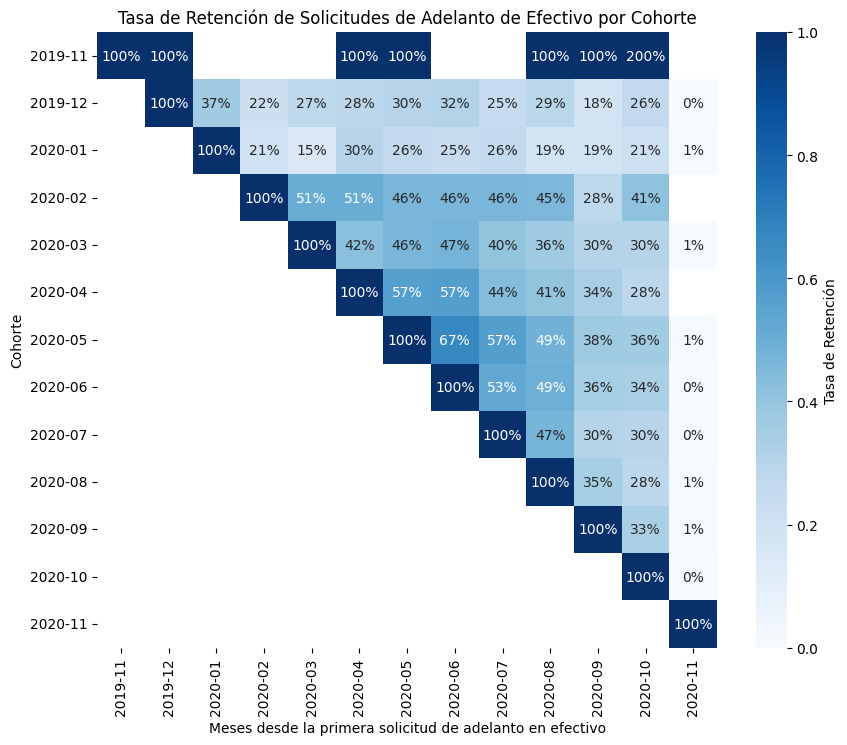

In [20]:
# Visualizar la tasa de retención de solicitudes usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Retención de Solicitudes de Adelanto de Efectivo por Cohorte')
sns.heatmap(data=retention_cash, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='Blues', cbar_kws={'label': 'Tasa de Retención'})
plt.xlabel('Meses desde la primera solicitud de adelanto en efectivo')
plt.ylabel('Cohorte')
plt.show()


In [21]:
# Calcular la tasa de abandono de solicitudes (1 - tasa de retención de solicitudes)
churn_cash = 1 - retention_cash
churn_cash


Mes,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
Cohorte,,,,,,,,,,,,,
2019-11,0.0,0.0,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000,-1.000000,NaN
2019-12,NaN,0.0,0.631944,0.781250,0.725694,0.715278,0.701389,0.684028,0.750000,0.708333,0.815972,0.739583,0.996528
2020-01,NaN,NaN,0.000000,0.794872,0.854701,0.700855,0.735043,0.752137,0.735043,0.811966,0.811966,0.786325,0.991453
2020-02,NaN,NaN,NaN,0.000000,0.494845,0.494845,0.536082,0.536082,0.536082,0.546392,0.721649,0.587629,NaN
2020-03,NaN,NaN,NaN,NaN,0.000000,0.575758,0.535354,0.525253,0.595960,0.636364,0.696970,0.696970,0.989899
2020-04,NaN,NaN,NaN,NaN,NaN,0.000000,0.431818,0.428030,0.560606,0.594697,0.662879,0.715909,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.334728,0.426778,0.514644,0.623431,0.635983,0.991632
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.468976,0.505171,0.644778,0.660807,0.997415
2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.528557,0.695391,0.701904,0.996493


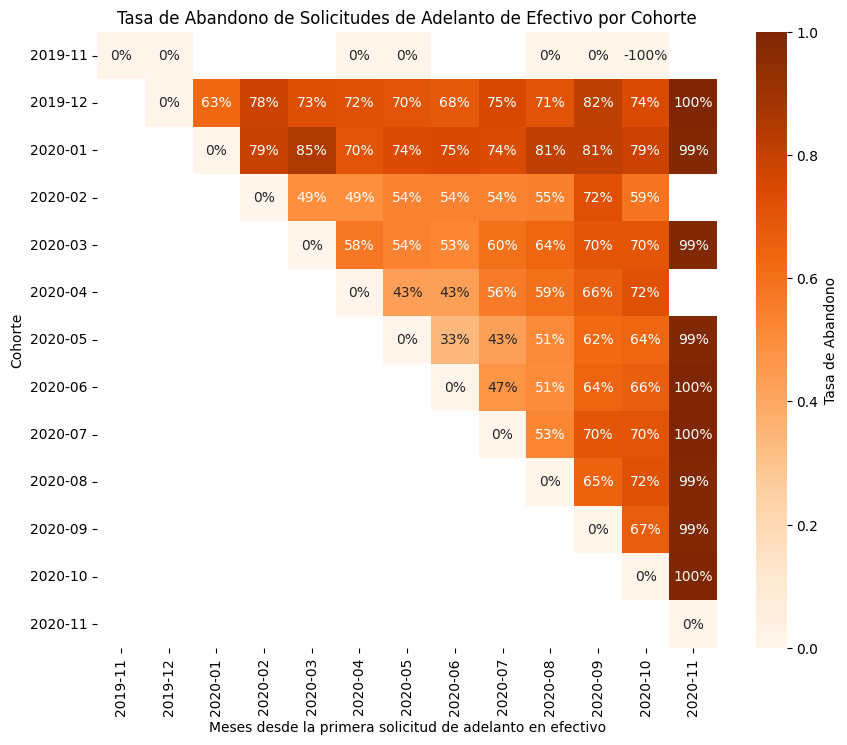

In [22]:
# Visualizar la tasa de abandono de solicitudes usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Abandono de Solicitudes de Adelanto de Efectivo por Cohorte')
sns.heatmap(data=churn_cash, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='Oranges', cbar_kws={'label': 'Tasa de Abandono'})
plt.xlabel('Meses desde la primera solicitud de adelanto en efectivo')
plt.ylabel('Cohorte')
plt.show()



### 1.0.1 Análisis de Cohortes para Fees




## Contract fees fields desciption

| **Campo**           | **Descripción**                                                                                                                                                                                                                                                                                                                                                       |
|----------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **status**           | Estado de las tarifas (¿se cobraron con éxito?). <br> **Valores posibles:** <br> - `confirmed`: El usuario realizó una acción que creó una tarifa. Normalmente se cobra en el momento del reembolso del CR. En casos raros, se confirma pero no se cobra debido a una oferta comercial. <br> - `rejected`: El último intento de cobrar la tarifa falló. <br> - `cancelled`: La tarifa fue creada y luego cancelada por alguna razón (principalmente para corregir problemas con tarifas fallidas). Si el aplazamiento falla, no se acepta y la fecha de reembolso sigue siendo la misma. <br> - `accepted`: Las tarifas se cobraron con éxito. |
| **category**         | Razón del incidente de la tarifa. <br> **Valores posibles:** <br> - `rejected_direct_debit`: Tarifas creadas cuando el banco del usuario rechaza el primer débito directo. <br> - `month_delay_on_payment`: Tarifas creadas cada mes hasta que se resuelve el incidente.                                                                                                         |
| **reason**           | Descripción de la tarifa.                                                                                                                                                                                                                                                                                                                                          |
| **created_at**       | Marca de tiempo de la creación de la tarifa.                                                                                                                                                                                                                                                                                                                       |
| **updated_at**       | Marca de tiempo de la última actualización de los detalles de la tarifa.                                                                                                                                                                                                                                                                                          |
| **paid_at**          | Marca de tiempo del pago de la tarifa.                                                                                                                                                                                                                                                                                                                             |
| **from_date**        | Aplica solo a tarifas por aplazamiento. Fecha inicial de reembolso para el CR.                                                                                                                                                                                                                                                                                     |
| **to_date**          | Aplica solo a tarifas por aplazamiento. Nueva fecha de reembolso para el CR.                                                                                                                                                                                                                                                                                       |
| **cash_request_id**  | ID único del CR asociado con esta tarifa.                                                                                                                                                                                                                                                                                                                          |
| **total_amount**     | Monto de la tarifa (incluido el IVA).                                                                                                                                                                                                                                                                                                                              |
| **charge_moment**    | Momento en que se cobrará la tarifa. <br> **Valores posibles:** <br> - `before`: La tarifa se cobrará en el momento de su creación. <br> - `after`: La tarifa se cobrará en el momento del reembolso del CR.                                                                                                                                                        |



In [23]:
# Cargar el dataset de tarifas o fees para análisis de cohortes de tarifas
fees = pd.read_csv('project_dataset/extract - fees - data analyst - .csv')


In [24]:
# Inspeccionar la estructura y el tipo de datos de 'fees'
fees.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21061 entries, 0 to 21060
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               21061 non-null  int64  
 1   cash_request_id  21057 non-null  float64
 2   type             21061 non-null  object 
 3   status           21061 non-null  object 
 4   category         2196 non-null   object 
 5   total_amount     21061 non-null  float64
 6   reason           21061 non-null  object 
 7   created_at       21061 non-null  object 
 8   updated_at       21061 non-null  object 
 9   paid_at          15531 non-null  object 
 10  from_date        7766 non-null   object 
 11  to_date          7766 non-null   object 
 12  charge_moment    21061 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 2.1+ MB


In [25]:

# Crear una copia del DataFrame para preservar el original
fs = fees.copy()



In [26]:
# Filtrar columnas relevantes para el análisis
fs = fs[["cash_request_id", "total_amount", "created_at"]]
fs.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21061 entries, 0 to 21060
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cash_request_id  21057 non-null  float64
 1   total_amount     21061 non-null  float64
 2   created_at       21061 non-null  object 
dtypes: float64(2), object(1)
memory usage: 493.7+ KB


In [27]:

# Convertir la columna 'created_at' en fees a tipo datetime para análisis temporal
fs['created_at'] = pd.to_datetime(fs['created_at'])
fs.head()


,cash_request_id,total_amount,created_at
0,14941.0,5.0,2020-09-07 10:47:27.423150+00:00
1,11714.0,5.0,2020-09-09 20:51:17.998653+00:00
2,23371.0,5.0,2020-10-23 10:10:58.352972+00:00
3,26772.0,5.0,2020-10-31 15:46:53.643958+00:00
4,19350.0,5.0,2020-10-06 08:20:17.170432+00:00


In [28]:


# Convertir la columna 'created_at' a una fecha sin zona horaria
fs['created_at'] = fs['created_at'].dt.tz_localize(None)
fs.head()


,cash_request_id,total_amount,created_at
0,14941.0,5.0,2020-09-07 10:47:27.423150
1,11714.0,5.0,2020-09-09 20:51:17.998653
2,23371.0,5.0,2020-10-23 10:10:58.352972
3,26772.0,5.0,2020-10-31 15:46:53.643958
4,19350.0,5.0,2020-10-06 08:20:17.170432


In [29]:

# Crear columna 'Mes' indicando el mes de cada solicitud
fs['Mes'] = fs['created_at'].dt.to_period('M')
fs.head()


,cash_request_id,total_amount,created_at,Mes
0,14941.0,5.0,2020-09-07 10:47:27.423150,2020-09
1,11714.0,5.0,2020-09-09 20:51:17.998653,2020-09
2,23371.0,5.0,2020-10-23 10:10:58.352972,2020-10
3,26772.0,5.0,2020-10-31 15:46:53.643958,2020-10
4,19350.0,5.0,2020-10-06 08:20:17.170432,2020-10


In [30]:

# Crear columna 'Cohorte' que indica el mes del primer cargo de cada cliente
fs['Cohorte'] = fs.groupby('cash_request_id')['created_at'].transform('min').dt.to_period('M')
fs.head()


,cash_request_id,total_amount,created_at,Mes,Cohorte
0,14941.0,5.0,2020-09-07 10:47:27.423150,2020-09,2020-09
1,11714.0,5.0,2020-09-09 20:51:17.998653,2020-09,2020-08
2,23371.0,5.0,2020-10-23 10:10:58.352972,2020-10,2020-10
3,26772.0,5.0,2020-10-31 15:46:53.643958,2020-10,2020-10
4,19350.0,5.0,2020-10-06 08:20:17.170432,2020-10,2020-10


In [31]:

# Calcular la cantidad de tarifas iniciales por cohorte
cohort_fees_initial = fs.groupby('Cohorte').agg(Num_Tarifas_Iniciales=('cash_request_id', 'nunique')).reset_index()
cohort_fees_initial


,Cohorte,Num_Tarifas_Iniciales
0,2020-05,14
1,2020-06,447
2,2020-07,856
3,2020-08,1922
4,2020-09,2640
5,2020-10,6930
6,2020-11,124


In [32]:

# Calcular el número de tarifas en cada cohorte para cada mes
cohort_fees_monthly = fs.groupby(['Cohorte', 'Mes']).agg(Num_Tarifas=('cash_request_id', 'nunique')).reset_index()
cohort_fees_monthly


,Cohorte,Mes,Num_Tarifas
0,2020-05,2020-05,14
1,2020-05,2020-06,5
2,2020-05,2020-07,2
3,2020-05,2020-08,1
4,2020-05,2020-09,1
5,2020-05,2020-10,1
6,2020-06,2020-06,447
7,2020-06,2020-07,196
8,2020-06,2020-08,74
9,2020-06,2020-09,42


In [33]:

# Calcular la tasa de retención de tarifas (número de tarifas de cada cohorte en cada mes / tarifas iniciales de la cohorte)
retention_fees = cohort_fees_monthly.pivot(index='Cohorte', columns='Mes',values='Num_Tarifas')
retention_fees = retention_fees.div(cohort_fees_initial.set_index('Cohorte')['Num_Tarifas_Iniciales'], axis=0)
retention_fees


Mes,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
Cohorte,,,,,,,
2020-05,1.0,0.357143,0.142857,0.071429,0.071429,0.071429,NaN
2020-06,NaN,1.000000,0.438479,0.165548,0.093960,0.082774,NaN
2020-07,NaN,NaN,1.000000,0.371495,0.200935,0.143692,NaN
2020-08,NaN,NaN,NaN,1.000000,0.356400,0.197190,NaN
2020-09,NaN,NaN,NaN,NaN,1.000000,0.360985,0.006439
2020-10,NaN,NaN,NaN,NaN,NaN,1.000000,0.014286
2020-11,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


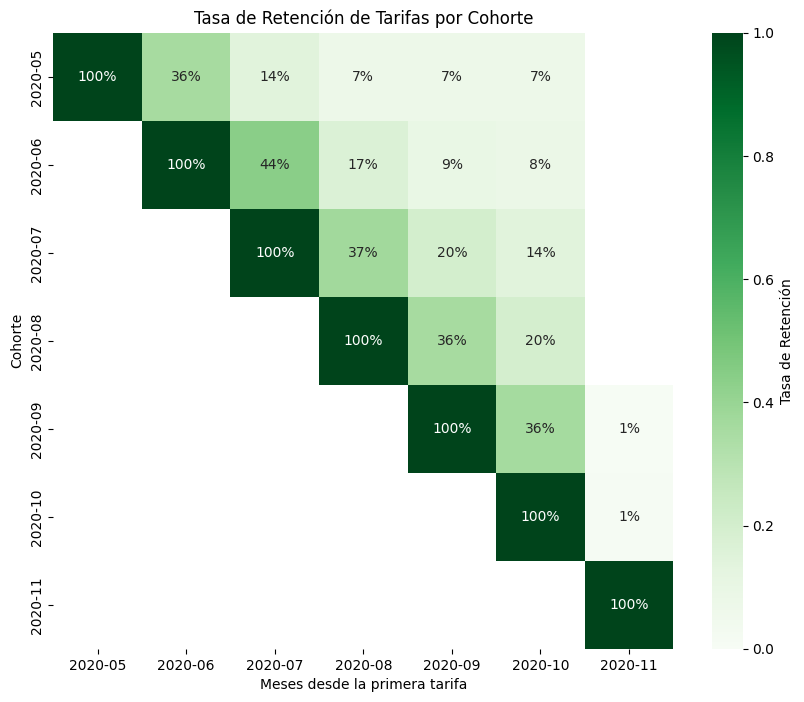

In [34]:

# Visualizar la tasa de retención de tarifas usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Retención de Tarifas por Cohorte')
sns.heatmap(data=retention_fees, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='Greens', cbar_kws={'label': 'Tasa de Retención'})
plt.xlabel('Meses desde la primera tarifa')
plt.ylabel('Cohorte')
plt.show()


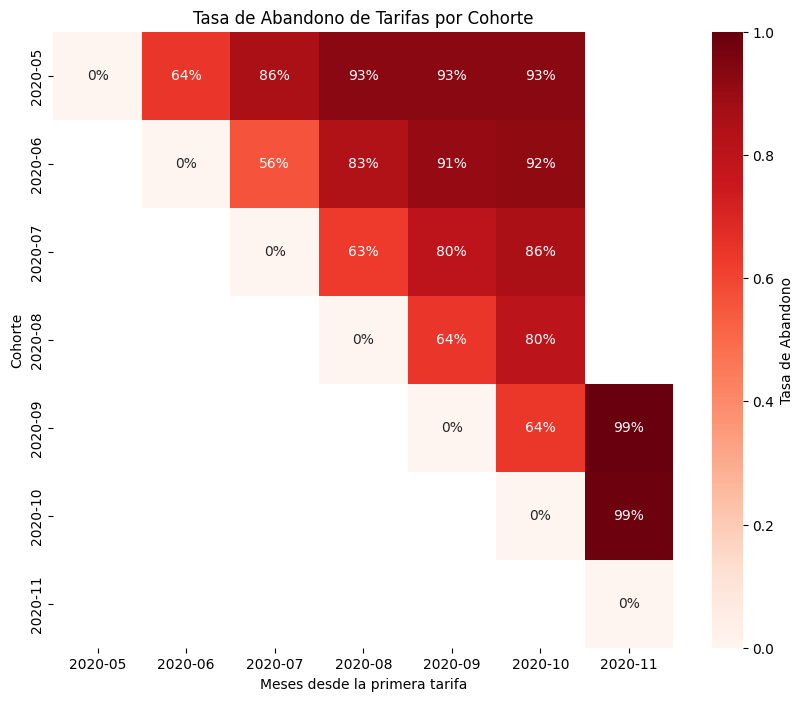

In [35]:

# Calcular la tasa de abandono de tarifas (1 - tasa de retención de tarifas)
churn_fees = 1 - retention_fees

# Visualizar la tasa de abandono de tarifas usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Abandono de Tarifas por Cohorte')
sns.heatmap(data=churn_fees, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='Reds', cbar_kws={'label': 'Tasa de Abandono'})
plt.xlabel('Meses desde la primera tarifa')
plt.ylabel('Cohorte')
plt.show()



## 2 Análisis de Cohortes Avanzado y la Extracción de Insights


El análisis de cohortes avanzado y la extracción de insights son componentes cruciales en el ámbit el análisis de datos y la toma de decisiones estratégicas en diversos campos,desde elmarketin igital hasta la gestión de productos y servicios.Ambos procesos permiten entender mejor el co mportamiento de los usuarios, identificar patrones significativos y tomar decisiones fundamentadas e atos. A continuación, se detallan algunas estrategias comunes para llevar a cabo estas prácticas:
### 2.1 Análisis de Cohortes Avanzado:
El análisis de cohortes se refiere a la agrupación de individuos que comparten una característic omún o que han experimentado un evento similar en un período específico de tiempo.El análisi vanzado de cohortes implica eluso de técnicas más sofisticadas para comprender mejor elcomportamiento de estos grupos a lo largo deltiempo y extraer insights valiosos.A continuación,s etallan técnicas y enfoques comunes:
1. Refinamiento de Cohortes:
    - Segmentación adicional de cohortes: Divide los grupos en subconjuntos más específicos basados en características demográficas (edad, género, ubicación), comportamiento specíficos (frecuencia de compra, interacciones en línea) o patrones de uso (horarios d so, dispositivos utilizados).Esto permite una comprensión más profunda de los comportamientos y necesidades de diferentes grupos de usuarios.
    - Utilización de técnicas de clustering: Aplica algoritmos de agrupamiento par dentificar subgrupos dentro de las cohortes principales.Esto te permite descubrir patrones más complejos y segmentar los datos de manera más precisa,lo que facilita l ersonalización de estrategias y acciones.
2. Análisis de Retención:
    - Seguimiento de la retención: Observa cómo cambia la cantidad de usuarios activo entro de cada cohorte a lo largo del tiempo.Esto te ayuda a comprender si los usuario ermanecen comprometidos con tu producto o servicio y a identificar posibles problema e retención.
    - Identificación de factores de retención: Examina qué factores influyen en la retención de los usuarios (como la calidad delproducto,la experiencia delusuario o la romociones).Luego,desarrolla estrategias para mejorar la retención basadas en esto allazgos,lo que puede incluir mejoras en la experiencia delusuario,ofertas especiale  programas de fidelización.
3. Cohortes Dinámicas:
    - Creación de cohortes dinámicas: Actualiza continuamente las cohortes para refleja os cambios en el comportamiento del usuario o las características del producto.Esto t ermite mantener un seguimiento preciso de la evolución del rendimiento a lo largo de iempo y adaptar tus estrategias en consecuencia.
    - Uso de modelos predictivos: Implementa modelos que puedan predecir elcomportamiento futuro de las cohortes en función de datos históricos y variables clave.Esto t yuda a anticipar tendencias y tomar decisiones proactivas, como la personalización d fertas o la optimización de la distribución de recursos.
4. Análisis de Recurrencia:
    - Estudio de la frecuencia de retorno: Analiza qué tan a menudo los usuarios regresa espués de su primera interacción con tu producto o servicio.Esto te permite entende a lealtad del cliente y su propensión a continuar utilizando tu oferta.
    - Identificación de patrones recurrentes: Busca patrones en el comportamiento de lo suarios que indican una alta probabilidad de regreso, como la frecuencia de compra o l articipación en actividades específicas.Estos patrones pueden ser clave para desarrolla strategias efectivas de retención y compromiso.
5. Análisis de Comportamiento:
    - Seguimiento del comportamiento individual: Examina cómo se comportan lo suarios dentro de cada cohorte a lo largo deltiempo. Esto te ayuda a identifica endencias, cambios de comportamiento y momentos clave en el ciclo de vida del usuario,
1 o que puede informar la optimización de la experiencia del usuario y la personalizació e las estrategias de marketing.
    - Identificación de patrones y puntos de inflexión: Busca momentos en los que e omportamiento de los usuarios cambie significativamente, como la adopción de nueva aracterísticas o la disminución de la actividad.Estos puntos de inflexión pueden se portunidades para la intervención y la mejora continua del producto o servicio.
### 2.2 Extracción de Insights:
La extracción de insights implica el proceso de identificar y comprender información significativa y útil a partir de los datos analizados.A continuación, se detallan algunas estrategias comunes par xtraer insights del análisis de cohortes:
1. Segmentación Avanzada:
    - Segmentación detallada de las cohortes: Divide los grupos en segmentos más específicos basados en características compartidas o comportamientos similares.Esto t ermite personalizar tus estrategias para satisfacer las necesidades únicas de cada segmento, lo que puede mejorar la efectividad de tus acciones y campañas.
    - Personalización de estrategias: Utiliza los segmentos identificados para adaptar tu strategias de marketing,comunicación y experiencia delusuario, lo que aumenta l elevancia y la efectividad de tus acciones y mejora la satisfacción del cliente.
2. Identificación de Tendencias:
    - Detección de tendencias a lo largo del tiempo: Analiza cómo evolucionan la étricas clave (como la retención o el compromiso) dentro de cada cohorte con el tiempo.
Esto te ayuda a identificar patrones y entender cómo ciertos eventos o cambios afecta l comportamiento de los usuarios, lo que puede informar decisiones estratégicas futuras.
    - Análisis de eventos específicos: Examina cómo eventos como lanzamientos de productos, campañas de marketing o cambios en el diseño impactan en el comportamient e las cohortes.Esto te proporciona información valiosa para la planificación futura  a evaluación del éxito de tus iniciativas.
3. Predicción y Modelado:
    - Utilización de modelos predictivos: Implementa modelos que puedan predecir e omportamiento futuro de las cohortes en función de datos históricos y variables clave.
Esto te ayuda a anticipar tendencias y tomar decisiones informadas sobre estrategia uturas, lo que puede aumentar la eficiencia y el éxito de tus acciones.
    - Evaluación de impacto: Evalúa el impacto potencialde cambios en productos,servicios o estrategias antes de implementarlos.Esto te permite tomar decisiones má ólidas y minimizar los riesgos asociados con nuevas iniciativas, lo que puede mejorar l entabilidad y la satisfacción del cliente a largo plazo.
4. Benchmarking y Comparación:
    - Comparación del rendimiento: Compara el rendimiento de diferentes cohortes  egmentos de usuarios para identificar áreas de fortaleza y oportunidades de mejora.
Esto te ayuda a entender tu posición en el mercado y a identificar estrategias par iferenciarte y destacarte entre la competencia.
    - Benchmarking contra competidores: Compara tus métricas con las de tus competidores o estándares de la industria para entender tu posición en el mercado y encontra portunidades para diferenciarte.Esto te proporciona información valiosa sobre la ejores prácticas y te ayuda a identificar áreas de mejora y oportunidades de crec1 miento.
5. Acciones Estratégicas:
    - Desarrollo de estrategias específicas: Utiliza los insights obtenidos para desarrolla strategias específicas destinadas a mejorar la retención, el compromiso y el crecimient e tu negocio.Esto puede incluir cambios en productos o servicios, ajustes en la estrategia de marketing o mejoras en la experiencia del cliente.
    - Evaluación continua: Evalúa regularmente la efectividad de tus estrategias a travé el análisis de cohortes en curso y realiza ajustes según sea necesario para optimizar lo esultados a lo largo del tiempo.Esto te permite adaptarte a los cambios en el mercad  mantener una ventaja competitiva a largo plazo.


In [36]:
# Agregar columnas de temporalidad
# Semana y mes de la solicitud
cr['Semana_Mes'] = cr['created_at'].dt.strftime('%U_%B') + '_' + cr['Mes'].dt.strftime('%Y')
# Día y semana de la solicitud
cr['Dia_Semana'] = cr['created_at'].dt.strftime('%A') + '_' + cr['Semana_Mes']
# Hora y dia de la solicitud
cr['Hora_Dia'] = cr['created_at'].dt.hour.astype(str) + '_' + cr['Dia_Semana']
cr.head()


,amount,created_at,user_id,transfer_type,Mes,Cohorte,Semana_Mes,Dia_Semana,Hora_Dia
0,100.0,2019-12-10 19:05:21.596873,804.0,regular,2019-12,2019-12,49_December_2019,Tuesday_49_December_2019,19_Tuesday_49_December_2019
1,100.0,2019-12-10 19:50:12.347780,231.0,regular,2019-12,2019-12,49_December_2019,Tuesday_49_December_2019,19_Tuesday_49_December_2019
2,100.0,2019-12-10 19:13:35.825460,191.0,regular,2019-12,2019-12,49_December_2019,Tuesday_49_December_2019,19_Tuesday_49_December_2019
3,99.0,2019-12-10 19:16:10.880172,761.0,regular,2019-12,2019-12,49_December_2019,Tuesday_49_December_2019,19_Tuesday_49_December_2019
4,100.0,2020-05-06 09:59:38.877376,7686.0,regular,2020-05,2020-05,18_May_2020,Wednesday_18_May_2020,9_Wednesday_18_May_2020


In [37]:

# Calcular la cantidad de adelanto de efectivo por cohorte y mes
cohort_revenue = cr.groupby(['Cohorte', 'Mes'])['amount'].sum().reset_index()
cohort_revenue = cohort_revenue.pivot(index='Cohorte', columns='Mes',values='amount')
cohort_revenue





Mes,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
Cohorte,,,,,,,,,,,,,
2019-11,1.0,100.0,NaN,NaN,NaN,100.0,10.0,NaN,NaN,10.0,5.0,6.0,NaN
2019-12,NaN,27197.0,10123.0,5881.0,7650.0,7900.0,8175.0,8805.0,6990.0,7790.0,4860.0,6655.0,100.0
2020-01,NaN,NaN,11464.0,2360.0,1660.0,3500.0,3020.0,2770.0,3010.0,2150.0,1970.0,2350.0,100.0
2020-02,NaN,NaN,NaN,8412.0,4740.0,4607.0,4350.0,4235.0,4405.0,4130.0,2555.0,3595.0,NaN
2020-03,NaN,NaN,NaN,NaN,9499.0,4250.0,4540.0,4850.0,4055.0,3390.0,2800.0,2700.0,50.0
2020-04,NaN,NaN,NaN,NaN,NaN,25736.0,14258.0,14320.0,11000.0,9915.0,7685.0,6450.0,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,NaN,44883.0,30143.0,25725.0,21224.0,16350.0,15305.0,350.0
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180903.0,92672.0,84491.0,60025.0,56525.0,400.0
2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180330.0,76873.0,49725.0,47313.0,500.0


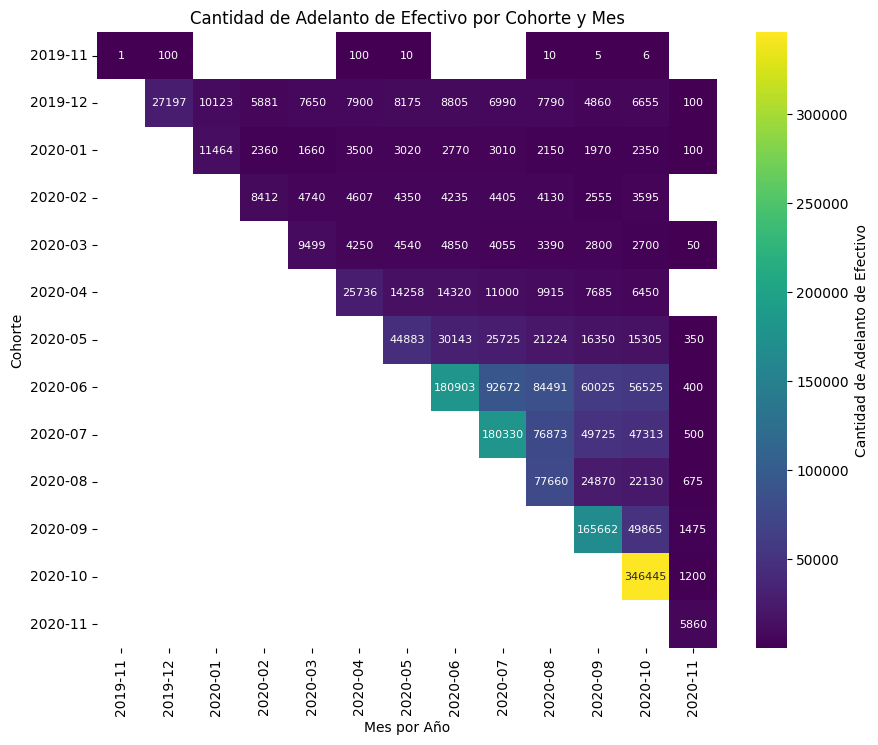

In [38]:
# Graficar la cantidad de adelanto de efectivo por cohorte y mes
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo por Cohorte y Mes')
sns.heatmap(data=cohort_revenue, annot=True, fmt='.0f', cmap='viridis',annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'})
plt.xlabel('Mes por Año')
plt.ylabel('Cohorte')
plt.show()




In [39]:

# Crear DataFrame de cohortes para el mes de '2020-03'
cohort_amount_2020_03 = cr[cr['Cohorte'] == '2020-03'].groupby('user_id')['amount'].sum().reset_index()
cohort_amount_2020_03




,user_id,amount
0,161.0,400.0
1,400.0,800.0
2,447.0,100.0
3,448.0,80.0
4,475.0,100.0
...,...,...
81,13975.0,650.0
82,14798.0,650.0
83,16345.0,400.0
84,21228.0,200.0


In [40]:

# Ordenar por el monto total para encontrar los 10 usuarios principales
sort_cohort_amount_2020_03 = cohort_amount_2020_03.sort_values(by='amount',ascending=False)
top_10_users = sort_cohort_amount_2020_03.head(10)
top_10_users



,user_id,amount
36,3377.0,1305.0
52,4297.0,1200.0
45,3617.0,1000.0
50,3948.0,950.0
20,2548.0,900.0
43,3557.0,900.0
9,680.0,850.0
1,400.0,800.0
77,4715.0,800.0
23,2841.0,750.0


In [41]:


# Filtrar para incluir solo los 10 usuarios seleccionados
amount_2020_03 = cr[cr['Cohorte'] == '2020-03'].groupby(['user_id','Mes'])['amount'].sum().reset_index()
cohort_amount_2020_03_top10 = amount_2020_03[amount_2020_03['user_id'].isin(top_10_users['user_id'])]
cohort_amount_2020_03_top10 = cohort_amount_2020_03_top10.pivot(index='user_id', columns='Mes', values='amount')
cohort_amount_2020_03_top10





Mes,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
user_id,,,,,,,,,
400.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,NaN
680.0,200.0,100.0,100.0,100.0,100.0,100.0,100.0,50.0,NaN
2548.0,100.0,100.0,100.0,100.0,100.0,200.0,NaN,200.0,NaN
2841.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,50.0,NaN
3377.0,300.0,150.0,270.0,200.0,185.0,100.0,50.0,NaN,50.0
3557.0,200.0,200.0,NaN,200.0,200.0,100.0,NaN,NaN,NaN
3617.0,200.0,NaN,200.0,100.0,200.0,100.0,100.0,100.0,NaN
3948.0,200.0,200.0,200.0,100.0,NaN,100.0,NaN,150.0,NaN
4297.0,200.0,200.0,200.0,200.0,200.0,100.0,100.0,NaN,NaN


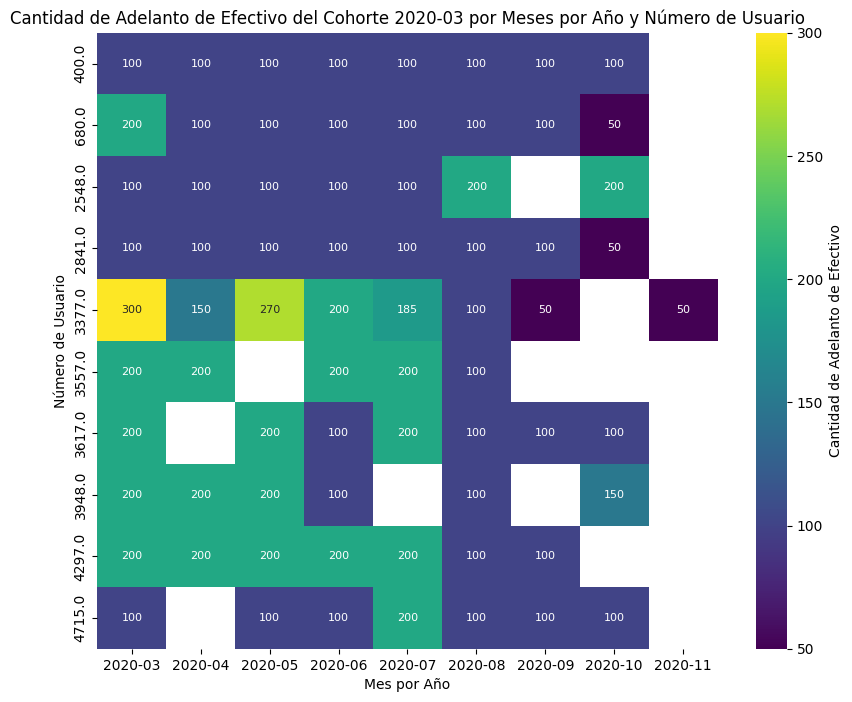

In [42]:

# Graficar la cantidad de adelanto de efectivo de un cohorte por meses y número de usuarios
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo del Cohorte 2020-03 por Meses por Año y Número de Usuario')
sns.heatmap(data=cohort_amount_2020_03_top10, annot=True, fmt='.0f', cmap='viridis', annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'})
plt.xlabel('Mes por Año')
plt.ylabel('Número de Usuario')
plt.show()




In [43]:

# Filtrar para calcular la cantidad de adelanto de efectivo por cohorte y semana
cohort_weekly_amount = cr[cr['Cohorte'] == '2020-03'].groupby(['user_id','Semana_Mes'])['amount'].sum().reset_index()
cohort_weekly_amount




,user_id,Semana_Mes,amount
0,161.0,09_March_2020,100.0
1,161.0,14_April_2020,100.0
2,161.0,19_May_2020,100.0
3,161.0,23_June_2020,100.0
4,400.0,10_March_2020,100.0
...,...,...,...
362,16345.0,31_August_2020,100.0
363,16345.0,36_September_2020,100.0
364,21228.0,13_March_2020,100.0
365,21228.0,32_August_2020,100.0


In [44]:

# Filtrar para incluir solo los 10 usuarios seleccionados
cohort_weekly_amount_top10 =cohort_weekly_amount[cohort_weekly_amount['user_id'].isin(top_10_users['user_id'])]
cohort_weekly_amount_top10 = cohort_weekly_amount_top10.pivot(index='user_id',columns='Semana_Mes', values='amount')
cohort_weekly_amount_top10



Semana_Mes,09_March_2020,10_March_2020,11_March_2020,12_March_2020,13_April_2020,14_April_2020,15_April_2020,16_April_2020,18_May_2020,19_May_2020,...,33_August_2020,34_August_2020,35_August_2020,35_September_2020,36_September_2020,37_September_2020,40_October_2020,41_October_2020,43_October_2020,44_November_2020
user_id,,,,,,,,,,,,,,,,,,,,,
400.0,NaN,100.0,NaN,NaN,NaN,100.0,NaN,NaN,100.0,NaN,...,NaN,NaN,NaN,NaN,NaN,100.0,100.0,NaN,NaN,NaN
680.0,100.0,NaN,100.0,NaN,NaN,100.0,NaN,NaN,NaN,100.0,...,NaN,NaN,NaN,100.0,NaN,NaN,50.0,NaN,NaN,NaN
2548.0,100.0,NaN,NaN,NaN,NaN,NaN,100.0,NaN,100.0,NaN,...,NaN,NaN,100.0,NaN,NaN,NaN,100.0,NaN,100.0,NaN
2841.0,NaN,NaN,100.0,NaN,NaN,NaN,100.0,NaN,NaN,100.0,...,NaN,NaN,NaN,NaN,NaN,100.0,50.0,NaN,NaN,NaN
3377.0,NaN,100.0,100.0,100.0,50.0,NaN,NaN,100.0,100.0,50.0,...,NaN,NaN,NaN,50.0,NaN,NaN,NaN,NaN,NaN,50.0
3557.0,NaN,200.0,NaN,NaN,NaN,200.0,NaN,NaN,NaN,NaN,...,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3617.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,100.0,NaN,NaN,NaN,100.0,NaN,NaN
3948.0,NaN,NaN,100.0,100.0,100.0,NaN,NaN,100.0,NaN,100.0,...,NaN,100.0,NaN,NaN,NaN,NaN,50.0,NaN,100.0,NaN
4297.0,NaN,NaN,200.0,NaN,200.0,NaN,NaN,NaN,NaN,200.0,...,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN


In [45]:


# Seleccionar las primeras 10 semanas
cohort_weekly_amount_top10 = cohort_weekly_amount_top10.loc[:,cohort_weekly_amount_top10.columns[:10]]
cohort_weekly_amount_top10





Semana_Mes,09_March_2020,10_March_2020,11_March_2020,12_March_2020,13_April_2020,14_April_2020,15_April_2020,16_April_2020,18_May_2020,19_May_2020
user_id,,,,,,,,,,
400.0,NaN,100.0,NaN,NaN,NaN,100.0,NaN,NaN,100.0,NaN
680.0,100.0,NaN,100.0,NaN,NaN,100.0,NaN,NaN,NaN,100.0
2548.0,100.0,NaN,NaN,NaN,NaN,NaN,100.0,NaN,100.0,NaN
2841.0,NaN,NaN,100.0,NaN,NaN,NaN,100.0,NaN,NaN,100.0
3377.0,NaN,100.0,100.0,100.0,50.0,NaN,NaN,100.0,100.0,50.0
3557.0,NaN,200.0,NaN,NaN,NaN,200.0,NaN,NaN,NaN,NaN
3617.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3948.0,NaN,NaN,100.0,100.0,100.0,NaN,NaN,100.0,NaN,100.0
4297.0,NaN,NaN,200.0,NaN,200.0,NaN,NaN,NaN,NaN,200.0


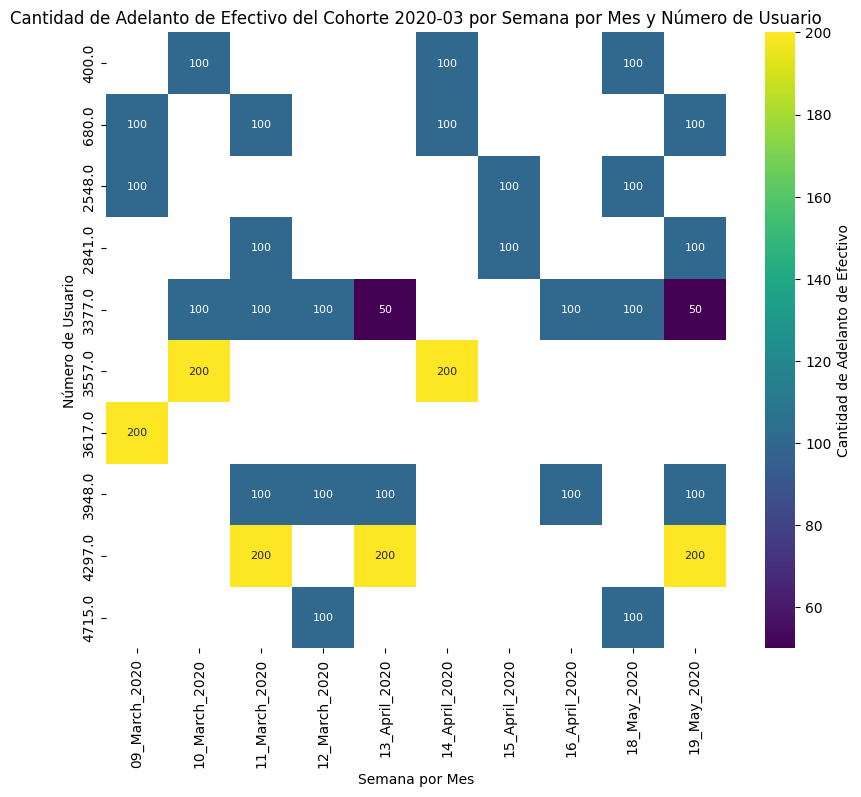

In [46]:
# Graficar la cantidad de adelanto de efectivo de los 10 principales usuarios por semana
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo del Cohorte 2020-03 por Semana por Mes y Número de Usuario')
sns.heatmap(data=cohort_weekly_amount_top10, annot=True, fmt='.0f', cmap='viridis', annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'})
plt.xlabel('Semana por Mes')
plt.ylabel('Número de Usuario')
plt.show()



In [47]:
# Filtrar para calcular la cantidad de adelanto de efectivo por cohorte y día de la semana
cohort_daily_amount = cr[ (cr['Cohorte'] == '2020-03') & (cr['Semana_Mes'] == '10_March_2020') ].groupby(['user_id', 'Dia_Semana'])['amount'].sum().reset_index()
cohort_daily_amount





,user_id,Dia_Semana,amount
0,400.0,Monday_10_March_2020,100.0
1,475.0,Monday_10_March_2020,100.0
2,479.0,Tuesday_10_March_2020,100.0
3,496.0,Wednesday_10_March_2020,100.0
4,575.0,Tuesday_10_March_2020,100.0
5,876.0,Thursday_10_March_2020,100.0
6,1101.0,Friday_10_March_2020,100.0
7,1280.0,Monday_10_March_2020,100.0
8,2197.0,Monday_10_March_2020,100.0
9,2976.0,Wednesday_10_March_2020,50.0


In [48]:
# Filtrar para incluir solo los 10 usuarios seleccionados
cohort_daily_amount_top10 = cohort_daily_amount[cohort_daily_amount['user_id'].isin(top_10_users['user_id'])]
cohort_daily_amount_top10 = cohort_daily_amount_top10.pivot(index='user_id',columns='Dia_Semana', values='amount')
cohort_daily_amount_top10




Dia_Semana,Monday_10_March_2020,Wednesday_10_March_2020
user_id,,
400.0,100.0,NaN
3377.0,100.0,NaN
3557.0,NaN,200.0


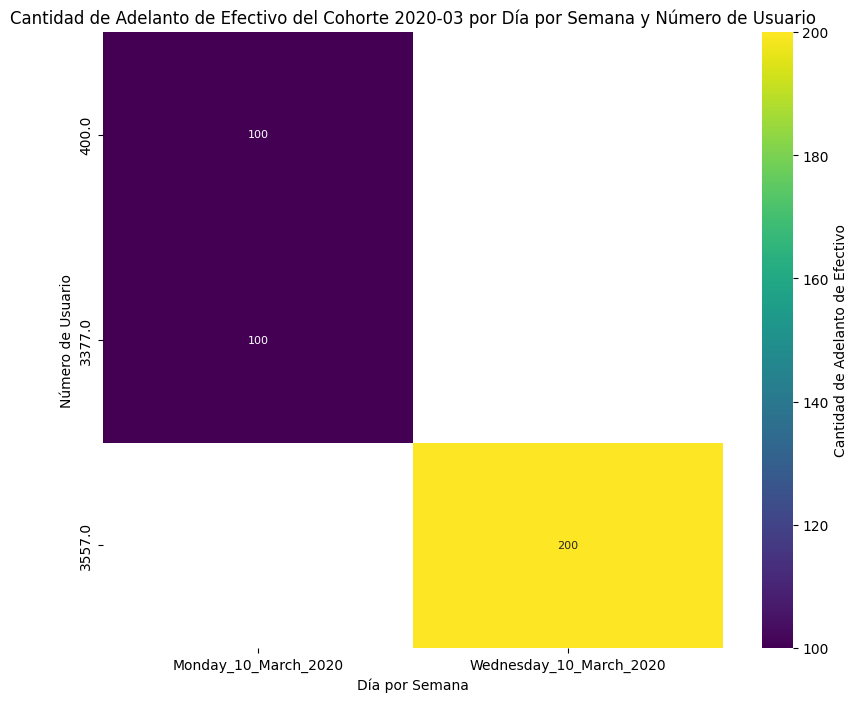

In [49]:
# Graficar la cantidad de adelanto de efectivo de los 10 principales usuarios por día de la semana
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo del Cohorte 2020-03 por Día por Semana y Número de Usuario')
sns.heatmap(data=cohort_daily_amount_top10, annot=True, fmt='.0f', cmap='viridis', annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'})
plt.xlabel('Día por Semana')
plt.ylabel('Número de Usuario')
plt.show()





In [50]:
# Filtrar para calcular la cantidad de adelanto de efectivo por cohorte y hora
cohort_hourly_amount = cr[(cr['Cohorte'] == '2020-03') & (cr['Semana_Mes'] == '10_March_2020') & (cr['Dia_Semana'] == 'Monday_10_March_2020')].groupby(['user_id', 'Hora_Dia'])['amount'].sum().reset_index()
cohort_hourly_amount




,user_id,Hora_Dia,amount
0,400.0,7_Monday_10_March_2020,100.0
1,475.0,9_Monday_10_March_2020,100.0
2,1280.0,19_Monday_10_March_2020,100.0
3,2197.0,15_Monday_10_March_2020,100.0
4,3377.0,13_Monday_10_March_2020,100.0
5,4474.0,10_Monday_10_March_2020,100.0
6,10430.0,15_Monday_10_March_2020,100.0


In [51]:
# Filtrar para incluir solo los 10 usuarios seleccionados
cohort_hourly_amount_top10 = cohort_hourly_amount[cohort_hourly_amount['user_id'].isin(top_10_users['user_id'])]
cohort_hourly_amount_top10 = cohort_hourly_amount_top10.pivot(index='user_id', columns='Hora_Dia', values='amount')
cohort_hourly_amount_top10




Hora_Dia,13_Monday_10_March_2020,7_Monday_10_March_2020
user_id,,
400.0,NaN,100.0
3377.0,100.0,NaN


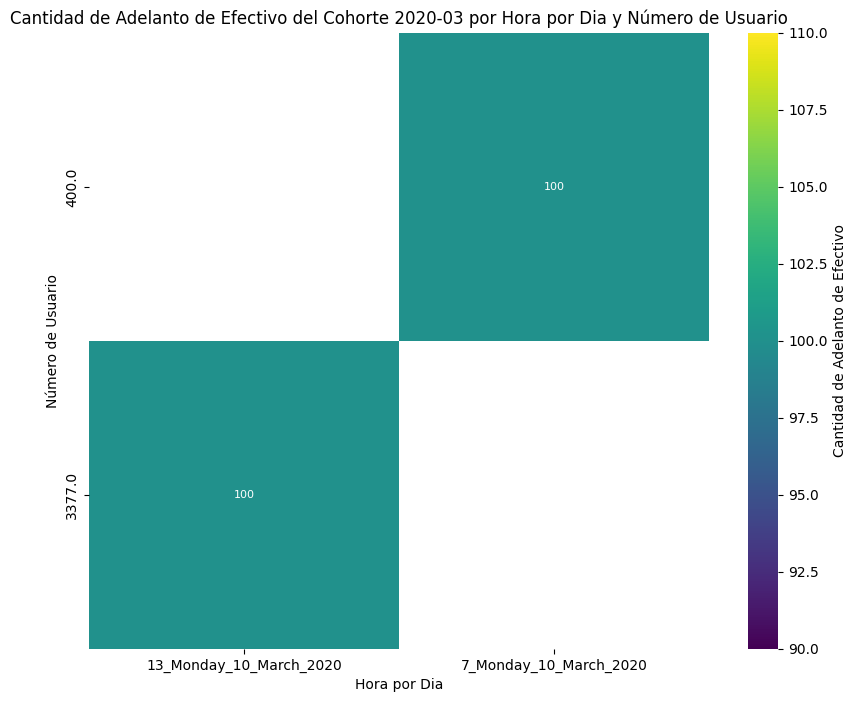

In [52]:
# Graficar la cantidad de adelanto de efectivo de los 10 principales usuarios por hora
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo del Cohorte 2020-03 por Hora por Dia y Número de Usuario')
sns.heatmap(data=cohort_hourly_amount_top10, annot=True, fmt='.0f', cmap='viridis', annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'})
plt.xlabel('Hora por Dia')
plt.ylabel('Número de Usuario')
plt.show()
